In [ ]:
!pip install -U sentence-transformers
!pip install --upgrade Gensim
!pip install fuzzywuzzy
!pip install --upgrade networkx
!pip install imblearn
exit()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 20.7 MB/s eta 0:00:00
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125923 sha256=cc5d9b0d762eac603b1cba4b994c96e52b45e52ea0a0d6afd4d64964b45c90bf
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
Successfully built sentence-transformers


In [ ]:
# !wget -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"
# !wget -c "http://nlp.stanford.edu/data/glove.twitter.27B.zip"
# !wget -c "https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.bin.gz"
# !unzip -o glove.twitter.27B.zip

In [ ]:
# !wget -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"

In [ ]:
import pandas as pd
import numpy as np
import scipy
import re
import hashlib #for hashing
#from fuzzywuzzy import fuzz #for similarity bw 2 strings
from IPython.display import display #interactive python -> display?
from collections import defaultdict
from matplotlib import pyplot
import networkx as nx #to study  complex networks
import time
import sys
from functools import reduce

import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem import SnowballStemmer

nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

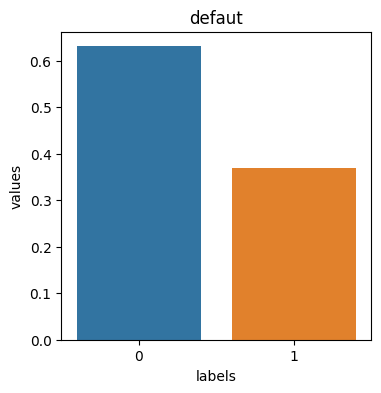

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
Quora = pd.read_csv('questions.csv')
temp = Quora.is_duplicate.value_counts()
df_class = pd.DataFrame({'labels': temp.index,
                   'values': temp.values/len(Quora)})
plt.figure(figsize = (4,4))
plt.title('defaut')
sns.set_color_codes("pastel")
sns.barplot(x = 'labels', y="C", data=df_class)
locs, labels = plt.xticks()
plt.show()

In [ ]:
lab_count=Quora.groupby('is_duplicate')['id'].count()
lab_count

is_duplicate
0    255045
1    149306
Name: id, dtype: int64

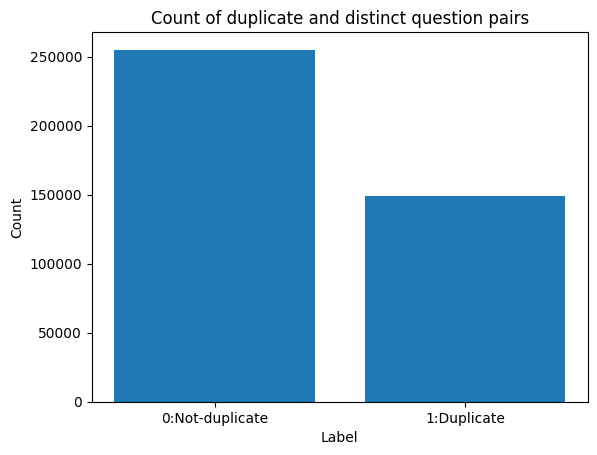

In [ ]:
plt.bar(["0:Not-duplicate","1:Duplicate"],lab_count)
plt.xlabel("Label")
plt.ylabel("Count")
plt.title("Count of duplicate and distinct question pairs")
plt.savefig("label_cnt")

In [ ]:
Quora.isna().sum()

id              0
qid1            0
qid2            0
question1       1
question2       2
is_duplicate    0
dtype: int64

In [ ]:
train_df = pd.read_csv('train.csv').dropna(how='any').reset_index(drop=True)
test_df = pd.read_csv('test.csv').dropna(how='any').reset_index(drop=True)

In [ ]:
train_df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,210774,415740,415741,What is the United Airlines reservations numbe...,What are the details of the United Airline 086...,0
1,16405,32741,32742,How you can improve your life?,What is the best way to improve your life?,1
2,44371,88361,88362,Can energy be converted back into mass? Is it ...,Is it possible to convert energy into mass?,1
3,275215,541157,541158,What are some good virtual assistant bots?,What is General Catalyst looking for in compan...,0
4,33397,66562,66563,Does India have the technical capability to de...,What place in India are BrahMos missiles produ...,0


data preprocessing

In [ ]:
stop_words = set(stopwords.words('english'))
stemmer = SnowballStemmer('english')

def preprocessing_text( txt):
        txt = txt.lower()
        txt = txt.replace(',000,000', 'm').replace(',000', 'k'
                ).replace('\xe2\x80\xb2', "'").replace('\xe2\x80\x99',
                "'").replace("can't", 'cannot').replace("don't",
                'do not').replace("isn't", 'is not').replace("you're",
                'you are').replace("you've", 'you have'
                                   ).replace("you'll", 'you will'
                ).replace("that'll", 'that will').replace("should've",
                'should have').replace("aren't", 'are not'
                ).replace("couldn't", 'could not').replace("didn't",
                'did not').replace("doesn't", 'does not'
                                   ).replace("hadn't", 'had not'
                ).replace("hasn't", 'has not').replace("haven't",
                'have not').replace("mustn't", 'must not'
                                    ).replace("wasn't", 'was not'
                ).replace("i'm", 'i am').replace("he's", 'he is'
                ).replace("she's", 'she is').replace("ain't", 'am not'
                ).replace('%', ' percent ').replace('\xe2\x82\xb9',
                ' rupee ').replace('$', ' dollar '
                                   ).replace('\xe2\x82\xac', ' euro '
                ).replace("'ll", ' will').replace("'ve", ' have'
                ).replace("it's", 'it is')

        txt = re.sub(r"[^A-Za-z0-9(),!.?\'\`]", ' ', txt)
        txt = re.sub(r"\'s", " 's ", txt)
        txt = re.sub(r"\'ve", " 've ", txt)
        txt = re.sub(r"n\'t", " 't ", txt)
        txt = re.sub(r"\'re", " 're ", txt)
        txt = re.sub(r"\'d", " 'd ", txt)
        txt = re.sub(r"\'ll", " 'll ", txt)
        txt = re.sub(r",", ' ', txt)
        txt = re.sub(r"\.", ' ', txt)
        txt = re.sub(r"!", ' ', txt)
        txt = re.sub(r"\(", ' ( ', txt)
        txt = re.sub(r"\)", ' ) ', txt)
        txt = re.sub(r"\?", ' ', txt)
        txt = re.sub(r"\s{2,}", ' ', txt)
        text_tokens = word_tokenize(txt)
        tokens_without_sw = [word for word in text_tokens if word not
                             in stop_words and len(word) != 1]
        txt = ' '.join(tokens_without_sw)
        txt = stemmer.stem(txt)

        return txt

In [ ]:
train_df['question1_clean'] = train_df['question1'].apply(preprocessing_text)
train_df['question2_clean'] = train_df['question2'].apply(preprocessing_text)
test_df['question1_clean'] = test_df['question1'].apply(preprocessing_text)
test_df['question2_clean'] = test_df['question2'].apply(preprocessing_text)


In [ ]:
test_df.head()

,id,qid1,qid2,question1,question2,is_duplicate,question1_clean,question2_clean
0,367731,719712,719713,Why did you stop or reduce your smoking of mar...,What are the laws with regard to marijuana in ...,0,stop reduce smoking marijuana,laws regard marijuana india
1,335252,657311,657312,How can I really start losing weight?,What is the most effective everlasting method ...,1,really start losing weight,effective everlasting method losing weight
2,384309,751472,751473,Do the Great Lakes have any salt water?,Why are oceans salty but the Great Lakes aren't?,1,great lakes salt wat,oceans salty great lak
3,355856,696929,696930,What is the best online free course to learn U...,What is the best free online game design course?,0,best online free course learn ui design beginn,best free online game design cours
4,335975,658717,658718,Should I feel bad when I download something il...,Why do I feel that something bad is going to h...,0,feel bad download something illeg,feel something bad going happen famili


representation

In [ ]:
import gensim
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models.fasttext import load_facebook_model
from transformers import XLNetTokenizer, XLNetModel
import torch
import torch.nn as nn
import torch.nn.functional as F
from sentence_transformers import SentenceTransformer

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import f_classif
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import Birch

from scipy.spatial.distance import cosine, cityblock, jaccard, \
    canberra, euclidean, minkowski, braycurtis

# **Bag of words**

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
lol, val = train_test_split(train_df, test_size=0.2, random_state=42)
train, test = lol, test_df

In [ ]:
train.reset_index(drop=True, inplace=True)
train.dropna(inplace=True)
test.reset_index(drop=True, inplace=True)
train.dropna(inplace=True)
val.reset_index(drop=True, inplace=True)
train.dropna(inplace=True)

In [ ]:
train

In [ ]:
vectorizer = CountVectorizer(ngram_range=(1, 1))
q1_train_v = vectorizer.fit(train['question1_clean']).vocabulary_
q2_train_v = vectorizer.fit(train['question2_clean']).vocabulary_
q1_val_v = vectorizer.fit(val['question1_clean']).vocabulary_
q2_val_v = vectorizer.fit(val['question2_clean']).vocabulary_
q1_test_v = vectorizer.fit(test['question1_clean']).vocabulary_
q2_test_v = vectorizer.fit(test['question2_clean']).vocabulary_

In [ ]:
vocab = set()
vocab = vocab.union(set(q1_train_v.keys()))
vocab = vocab.union(set(q2_train_v.keys()))
vocab = vocab.union(set(q1_test_v.keys()))
vocab = vocab.union(set(q2_test_v.keys()))
vocab = vocab.union(set(q1_val_v.keys()))
vocab = vocab.union(set(q2_val_v.keys()))
vocab = set([x.lower() for x in vocab])
print(len(vocab))
vocab_list = list(vocab)
vocab_dict = { vocab_list[i]:i for i in range(len(vocab))}
print(len(vocab_dict))

In [ ]:
vectorizer = CountVectorizer(ngram_range=(1, 1), vocabulary=vocab_dict)
v_train = vectorizer.transform(train['question1_clean'] + ' ' + train['question2_clean'])
v_test = vectorizer.transform(test['question1_clean'] + ' ' + test['question2_clean'])
v_val = vectorizer.transform(val['question1_clean'] + ' ' + val['question2_clean'])

In [ ]:
train_labels = train['is_duplicate'].values
val_labels = val['is_duplicate'].values
test_labels = test['is_duplicate'].values

>sgd regressor

In [ ]:
numtrainingpoints = v_train.shape[0]
print(numtrainingpoints)

In [ ]:
from sklearn.linear_model import SGDClassifier

def iter_minibatches(chunksize, numtrainingpoints):
    chunkstartmarker = 0
    while chunkstartmarker + chunksize < numtrainingpoints:
        chunkrows = range(chunkstartmarker, chunkstartmarker + chunksize)
        X_chunk, y_chunk = v_train[chunkrows], train_labels[chunkrows]
        yield X_chunk, y_chunk
        chunkstartmarker += chunksize

# Replace with your actual dataset dimensions
numtrainingpoints = v_train.shape[0]
#num_features = len(v_train[0])

batcherator = iter_minibatches(chunksize=1000, numtrainingpoints=numtrainingpoints)
model = SGDClassifier()

# Train model
for X_chunk, y_chunk in batcherator:
    model.partial_fit(X_chunk, y_chunk, classes=[0, 1])  # Assuming binary classification



In [ ]:
train_labels

In [ ]:
#SGD
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
# accuracy of validation set
pred_val = model.predict(v_val)
print('Train accuracy:', accuracy_score(val_labels, pred_val))
# accuracy of test set
pred_test = model.predict(v_test)
acc = accuracy_score(test_labels, pred_test)
f1 = f1_score(test_labels, pred_test)
prec = precision_score(test_labels, pred_test)
rec = recall_score(test_labels, pred_test)
cm = confusion_matrix(test_labels, pred_test)
print(f'Test accuracy: {acc}')
print(f'precision: {prec}')
print(f'recall: {rec}')
print(f'f1 score: {f1}')
print(f'confusion matrix: {cm}')

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
# Get raw decision values
raw_decision_values = model.decision_function(v_test)
# Apply sigmoid to get probabilities
pred_scores = 1 / (1 + np.exp(-raw_decision_values))
# Compute ROC curve and ROC area for each class
fpr, tpr, _ = roc_curve(test_labels, pred_scores)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for SGD Classifier with Bag of Words representation')
plt.legend(loc='lower right')
plt.show()

In [ ]:
print(classification_report(test_labels, pred_test))

cross validation---------

In [ ]:
from sklearn.model_selection import cross_val_score,KFold
from sklearn.model_selection import StratifiedKFold

model = SGDClassifier()
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
#logreg_score=cross_val_score(logreg,X,Y,cv=kf)
sgd_score = cross_val_score(model, v_train, train_labels, cv = kf)
print("Cross Validation Scores are {}".format(sgd_score))
print("Average Cross Validation score :{}+/- {}".format(sgd_score.mean()*100,sgd_score.std()*100))

-----------------

Word2Vec

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


apply embedding

In [ ]:
!pip install gensim==4.3.2

In [ ]:
import re
import pandas as pd
import numpy as np
from gensim.models import KeyedVectors
# import nltk
# nltk.download('punkt')
# nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

embed_lookup = KeyedVectors.load_word2vec_format('/content/drive/MyDrive/CS_412_IML/GoogleNews-vectors-negative300.bin.gz', binary= True)

In [ ]:
def process(text):
    text = re.sub(r'[^\w\s]','',text)
    text = re.sub(r"\d+", "", text)
    word_tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    filtered_sentence = [w for w in word_tokens if not w.lower() in stop_words]
    if not filtered_sentence:
        # Handle the case where there are no valid words
        return np.zeros(300)
    features = np.zeros((len(filtered_sentence), 300))
    for j, word in enumerate(filtered_sentence):
        if word in embed_lookup.index_to_key:
            features[j] = embed_lookup[word]
        else:
            pass
    return np.nanmean(features, axis=0)

def w2v_embedding(text1, text2):
    q1 = process(text1)
    q2 = process(text2)
    # print("q1:", q1.shape)
    # print("q2:", q2.shape)
        # Check if q1 and q2 are empty arrays
    return np.concatenate((q1,q2))

x = w2v_embedding("How are you finish?", "Whats up?")
print(x.shape)

(600,)


In [ ]:
train_df

,id,qid1,qid2,question1,question2,is_duplicate,question1_clean,question2_clean
0,210774,415740,415741,What is the United Airlines reservations numbe...,What are the details of the United Airline 086...,0,united airlines reservations number answ,details united airline 086 plan
1,16405,32741,32742,How you can improve your life?,What is the best way to improve your life?,1,improve lif,best way improve lif
2,44371,88361,88362,Can energy be converted back into mass? Is it ...,Is it possible to convert energy into mass?,1,energy converted back mass practically poss,possible convert energy mass
3,275215,541157,541158,What are some good virtual assistant bots?,What is General Catalyst looking for in compan...,0,good virtual assistant bot,general catalyst looking companies comes bots ...
4,33397,66562,66563,Does India have the technical capability to de...,What place in India are BrahMos missiles produ...,0,india technical capability design produce miss...,place india brahmos missiles produc
...,...,...,...,...,...,...,...,...
323473,306449,601672,601673,Where do I get a call girl?,Where do I get call girls?,1,get call girl,get call girl
323474,72985,145042,145043,How should I prepare for Accenture robotic aut...,How can I prepare for manual testing interview...,0,prepare accenture robotic automation testing i...,prepare manual testing interview tc
323475,102536,203437,203438,What is the relationship between mapR and Hadoop?,What is the relationship between MySQL and Had...,0,relationship mapr hadoop,relationship mysql hadoop
323476,179478,354520,354521,Which past superstar do people think should re...,Who are WWE superstar John Cena's real life fr...,0,past superstar people think return ww,wwe superstar john cena 's real life friends ww


In [ ]:
train_df.reset_index(drop=True, inplace=True)
train_df.dropna(inplace=True)
test_df.reset_index(drop=True, inplace=True)
test_df.dropna(inplace=True)

In [ ]:
# train_df_word2vec = train_df
# lol_word2vec, val_word2vec = train_test_split(train_df_word2vec, test_size=0.2, random_state=42)
# train_word2vec, test_word2vec = lol_word2vec, test_df

In [ ]:
# train_word2vec.reset_index(drop=True, inplace=True)
# train_word2vec.dropna(inplace=True)
# test_word2vec.reset_index(drop=True, inplace=True)
# train_word2vec.dropna(inplace=True)
# val_word2vec.reset_index(drop=True, inplace=True)
# train_word2vec.dropna(inplace=True)

In [ ]:
train_labels_word2vec = train_df['is_duplicate']
# val_labels_word2vec = val_word2vec['is_duplicate'].values
test_labels_word2vec = test_df['is_duplicate']

In [ ]:
 np.isnan([np.nan, np.nan]).any()

True

In [ ]:
train_df.isna().sum()

id                 0
qid1               0
qid2               0
question1          0
question2          0
is_duplicate       0
question1_clean    0
question2_clean    0
dtype: int64

In [ ]:
from tqdm import tqdm
numtrainingpoints = train_df.shape[0]
print(numtrainingpoints)

from sklearn.linear_model import SGDClassifier

def iter_minibatches(chunksize, numtrainingpoints):
    chunkstartmarker = 0

    while chunkstartmarker + chunksize < numtrainingpoints:
        chunkrows = range(chunkstartmarker, chunkstartmarker + chunksize)
        X1_chunk_raw, X2_chunk_raw, y_chunk = train_df.loc[chunkrows, 'question1_clean'], train_df.loc[chunkrows, 'question2_clean'], train_df.loc[chunkrows, 'is_duplicate']
        X_chunk = []

        for text1, text2 in zip(list(X1_chunk_raw), list(X2_chunk_raw)):
          embed = w2v_embedding(text1, text2)
          if np.isnan(embed).any():
            print("true")
          X_chunk.append(embed)
          #print(np.isnan(embed))
        yield X_chunk, y_chunk
        chunkstartmarker += chunksize


batcherator = iter_minibatches(chunksize=1000, numtrainingpoints=numtrainingpoints)
model = SGDClassifier()

#Train model
for X_chunk, y_chunk in tqdm(batcherator):
  try:
    #print(np.isnan(X_chunk))
    model.partial_fit(X_chunk, y_chunk, classes=[0, 1])  # Assuming binary classification
  except:
    print(X_chunk,len(y_chunk))
    assert 2==1

# # Train model
# for X_chunk, y_chunk in batcherator:
#     model.partial_fit(X_chunk, y_chunk, classes=[0, 1])  # Assuming binary classification


323478


298it [4:31:09, 54.86s/it]

embedding for test df

In [ ]:
X1_test_raw, X2_test_raw = test_df['question1_clean'], test_df['question2_clean']
X_test = []
for text1, text2 in zip(list(X1_test_raw), list(X2_test_raw)):
          embed = w2v_embedding(text1, text2)
          if np.isnan(embed).any():
            print("true")
          X_test.append(embed)

In [ ]:
X_test[:10]

In [ ]:
# Now make predictions with trained model
# y_predicted = model.predict(X_test)

#SGD
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
# # accuracy of validation set
# pred_val_word2vec = model.predict(val_labels_word2vec)
# print('Train accuracy:', accuracy_score(val_labels_word2vec, pred_val_word2vec))
# accuracy of test set
pred_test_word2vec = model.predict(X_test)
acc = accuracy_score(test_df['is_duplicate'], pred_test_word2vec)
f1 = f1_score(test_df['is_duplicate'], pred_test_word2vec)
prec = precision_score(test_df['is_duplicate'], pred_test_word2vec)
rec = recall_score(test_df['is_duplicate'], pred_test_word2vec)
cm = confusion_matrix(test_df['is_duplicate'], pred_test_word2vec)
print(f'accuracy: {acc}')
print(f'precision: {prec}')
print(f'recall: {rec}')
print(f'f1 score: {f1}')
print(f'confusion matrix: {cm}')

accuracy: 0.6831086929640163
precision: 0.5921899066775392
recall: 0.4401791426743442
f1 score: 0.504993142879218
confusion matrix: [[42171  9002]
 [16625 13072]]


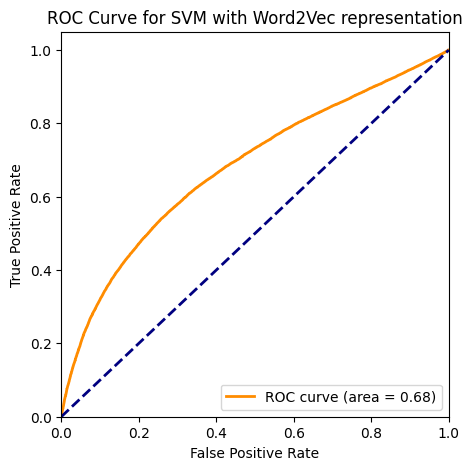

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
# Get raw decision values
raw_decision_values = model.decision_function(X_test)
# Apply sigmoid to get probabilities
pred_scores = 1 / (1 + np.exp(-raw_decision_values))
# Compute ROC curve and ROC area for each class
fpr, tpr, _ = roc_curve(test_df['is_duplicate'], pred_scores)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for SVM with Word2Vec representation')
plt.legend(loc='lower right')
plt.show()

In [ ]:
print(classification_report(test_df['is_duplicate'], pred_test_word2vec))

              precision    recall  f1-score   support

           0       0.72      0.82      0.77     51173
           1       0.59      0.44      0.50     29697

    accuracy                           0.68     80870
   macro avg       0.65      0.63      0.64     80870
weighted avg       0.67      0.68      0.67     80870



In [ ]:
#cross val
from sklearn.model_selection import cross_val_score,KFold
from sklearn.model_selection import StratifiedKFold
# model = SGDClassifier()
# kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
# #logreg_score=cross_val_score(logreg,X,Y,cv=kf)
# sgd_score = cross_val_score(model, train_df, train_df['is_duplicate'], cv = kf)
# print("Cross Validation Scores are {}".format(sgd_score))
# print("Average Cross Validation score :{}+/- {}".format(sgd_score.mean()*100,sgd_score.std()*100))
# Define your cross-validation strategy
cv = KFold(n_splits=5, shuffle=True, random_state=1)  # You can adjust the number of splits as needed

# Create an empty list to store cross-validation scores
cv_scores = []

# Perform cross-validation
for train_index, test_index in tqdm(cv.split(train_df)):
    X_train, X_test = train_df.iloc[train_index], train_df.iloc[test_index]

    batcherator_train = iter_minibatches(chunksize=1000, numtrainingpoints=len(X_train))
    X_train_cv, y_train_cv = next(batcherator_train)

    # Train the model using partial_fit
    model.partial_fit(X_train_cv, y_train_cv, classes=[0, 1])

    # Test the model on the validation set and calculate the score
    batcherator_test = iter_minibatches(chunksize=1000, numtrainingpoints=len(X_test))
    X_test_cv, y_test_cv = next(batcherator_test)

    score = model.score(X_test_cv, y_test_cv)
    cv_scores.append(score)

# Print the cross-validation scores
print("Cross-Validation Scores:", cv_scores)
print("Mean CV Score:", np.mean(cv_scores))

5it [09:31, 114.35s/it]

Cross-Validation Scores: [0.719, 0.701, 0.752, 0.628, 0.717]
Mean CV Score: 0.7034
